# Aprendizaje Automatico (CEIoT): Trabajo Practico N°1
## Alumno: Gonzalo Carvallo (i0810)

# Resolvemos los ejercicios de TP1 y TP2 usando árboles de decisión

## TP1 - Regresión de calidad de vino portugués "Vinho Verde"

En el TP1 se trabajó con un dataset de vinos portugués "Vinho Verde" en la variante tinta. Se cuenta con variables fisicoquímicas (entradas) y un puntaje de clasificación de tipo de vino. El análisis lo hicimos en el TP1, aquí vamos a ir directamente a implementar el modelo.

Se importan todas las librerias que usaremos. Luego leemos el dataset y preparamos todo, igual que en el TP1.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [4]:
# Leemos el dataset
wine_df = pd.read_csv("datasets/winequality-red.csv")

# Obtenemos a X e y.
# Para X usamos todas las columnas menos el target
X = wine_df.drop(columns=["quality"])
y = wine_df["quality"]

print(f"La forma de X es {X.shape}")
print(f"La forma de y es {y.shape}")

# Separamos el dataset en training y test
from sklearn.model_selection import train_test_split

# Como no hay una buena distribución de valores entre las calidades de vino, usamos el argumento opcional 
# para que se mantenga la proporción en los conjuntos de entrenamiento y testeo. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Como estamos trabajando con árboles, no vamos a realizar ninguna normalización

# Cargamos las métricas de evaluación que usamos en el TP1
from sklearn.metrics import r2_score, mean_absolute_error



La forma de X es (1599, 11)
La forma de y es (1599,)


Ya con el dataset leido y separado el entrenamiento y validación, podemos a realizar el entrenamiento.

Antes de entrenar el modelo, vamos a realizar una busqueda de hiperparametros. Vamos a usar una validación cruzada de 5 folds y una busqueda de grilla.

Para este caso vamos usar el podado de arboles, usando el coeficiente alpha (la busqueda tambien se podria haber hecho jugando con niveles del arbol o cantidad de muestra por hoja).

In [5]:
# Llamamos a GridSearch de sklearn
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [10]:
# Creamos el modelo base para buscar los hiperparámetros
from sklearn.tree import DecisionTreeRegressor

# Creamos el árbol
reg_tree = DecisionTreeRegressor(criterion='squared_error', splitter='best', 
                                 max_depth=None, min_samples_split=2, min_samples_leaf=1)



In [11]:
# Hacemos la búsqueda de grilla
grid_wine = GridSearchCV(reg_tree,
                         {"ccp_alpha": np.linspace(0, 100, 1001)},
                         refit=True,
                         cv=StratifiedKFold(n_splits=5, shuffle=True),
                         scoring='neg_mean_absolute_error',
                         n_jobs=-1)
grid_wine.fit(X_train, y_train)

# El mejor valor de hiperparámetros es:
print(grid_wine.best_params_)



{'ccp_alpha': 0.0}


Nos quedamos con el mejor modelo elegido en nuestra búsqueda.

In [12]:
best_tree_wine = grid_wine.best_estimator_


Ya elegido el mejor modelo, vamos a entrenar y evaluar el modelo.

In [19]:
# Entrenamos al modelo
best_tree_wine.fit(X_train, y_train)

# Evaluamos el modelo
y_pred = best_tree_wine.predict(X_test)
rsquare_tree = r2_score(y_test, y_pred)
mae_tree = mean_absolute_error(y_test, y_pred)

print(f"El mejor árbol tuvo un coeficiente de ajuste (R^2) igual a {rsquare_tree}")
print(f"El mejor árbol tuvo un MAE de {mae_tree}")


El mejor árbol tuvo un coeficiente de ajuste (R^2) igual a 0.14280525455536053
El mejor árbol tuvo un MAE de 0.396875


Comparando los modelos que realizamos:

- Modelo de regresion lineal
- Modelo de regresión multiple
- Arbol de decisión

Las metricas que obtuvimos son:

| Modelo              | MAE  | R2   |
|---------------------|------|------|
| Regresión lineal    | 0.50 | 0.37 |
| Regresión multiple  | 0.50 | 0.37 |
| Arbol de decisión   | 0.40 | 0.14 |

En función a estos resultados y complejidad de los modelos, discutir cual es el mejor modelo. Algo extra que se puede hacer si desean, es ver el árbol que se arma y determinar en los primeros niveles, que son las cualidades mas importantes del vino usando graphwiz (ver el notebook que hicimos en clase).

## TP2 - Clasificación de usuarios en campaña de red social

En el TP2 se trabajó con un dataset de publicidad que lanzó una campaña de publicidad en una red social. Se cuenta con datos de la persona tales como `genero`, `edad` y `salario estimado`. Además se registró si el usuario luego compró el producto que la publicidad hacía referencia.

Por lo que primero leemos el dataset y preparamos todo, igual que en el TP2.

In [20]:
# Leemos el dataset
social_df = pd.read_csv("datasets/Social_Network_Ads.csv")

# Dropeamos la columna que identifica a los usuarios
social_df.drop(columns="User ID", inplace=True)

# Generamos dummies para genero
social_df = pd.get_dummies(social_df, columns=["Gender"], drop_first=True)

# Obtenemos a X e y.
# Para X usamos todas las columnas menos el target
X = social_df.drop(columns="Purchased")
y = social_df["Purchased"]

print(f"La forma de X es {X.shape}")
print(f"La forma de y es {y.shape}")

# Separamos el dataset en training y test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, 
                                                    random_state=42, stratify=y)

# Como estamos trabajando con árboles, no vamos a realizar ninguna normalización

# Cargamos las métricas de evaluación que usamos en el TP2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, fbeta_score


La forma de X es (400, 3)
La forma de y es (400,)


Ya con el dataset leído y separado el entrenamiento y validación, podemos a realizar el entrenamiento.

Antes de entrenar el modelo, vamos a realizar una búsqueda de hiperparametros. Vamos a usar una validación cruzada de 5 folds y una búsqueda de grilla.

Para este caso vamos usar el podado de árboles, usando el coeficiente alpha (ccp_alpha). Además vamos a buscar el mejor criterio (Índice de Gini o Entropía).

In [21]:
# Creamos el modelo base para buscar los hiperparámetros
from sklearn.tree import DecisionTreeClassifier

# Creamos el árbol
clas_tree = DecisionTreeClassifier(splitter='best', max_depth=None, min_samples_split=2, 
                                   min_samples_leaf=1)


In [24]:
# Hacemos la búsqueda de grilla, como no podemos usar f0.5, vamos a usar a f1
from sklearn.model_selection import GridSearchCV, StratifiedKFold

grid_social = GridSearchCV(clas_tree,
                           {"max_depth": np.arange(1, 11),
                            "criterion": ["gini", "entropy"]},
                           refit=True,
                           cv=StratifiedKFold(n_splits=5, shuffle=True),
                           scoring='f1',
                           n_jobs=-1)
grid_social.fit(X_train, y_train)

# El mejor valor de hiperparámetros es:
print(grid_social.best_params_)


{'criterion': 'gini', 'max_depth': 2}


Nos quedamos con el mejor modelo elegido en nuestra búsqueda.

In [25]:
best_tree_social = grid_social.best_estimator_


Ya elegido el mejor modelo, vamos a entrenar y evaluar el modelo.

In [26]:
# Entrenamos al modelo
best_tree_social.fit(X_train, y_train)

# Evaluamos el modelo
y_pred = best_tree_social.predict(X_test)
cm_tree = confusion_matrix(y_test, y_pred)
f0_5_tree = fbeta_score(y_test, y_pred, zero_division=0, beta=0.5)

print(f"El mejor árbol tuvo un f0.5 de {f0_5_tree}")


El mejor árbol tuvo un f0.5 de 0.844155844155844


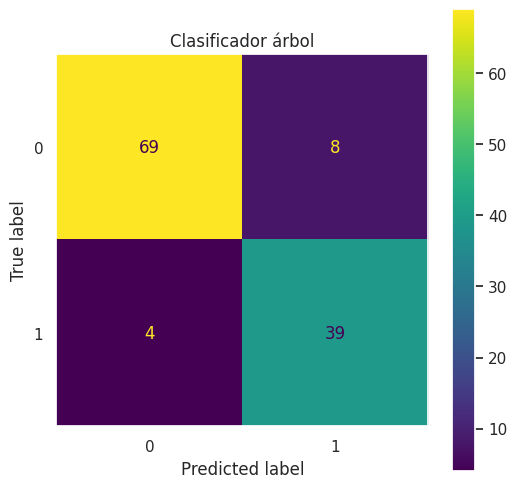

In [27]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_tree,
                              display_labels=best_tree_social.classes_)

fig, ax = plt.subplots(figsize=(6,6))
ax.grid(False)
disp.plot(ax=ax)
ax.set_title("Clasificador árbol");


Comparando los modelos que realizamos:

- Modelo de regresión logística
- Modelo kNN
- Árbol de decisión

Las métricas que obtuvimos son:

| Modelo              | F0.5 | Precisión | Especificidad |
|---------------------|------|-----------|---------------|
| Regresión logistica | ____ |    ____   |      ____     |
| kNN                 | ____ |    ____   |      ____     |
| Arbol de decisión   | ____ |    ____   |      ____     |


                Modelo      F0.5  Precisión  Especificidad
0  Regresión logística  0.000000   0.000000       1.000000
1                  kNN  0.771429   0.818182       0.922078
2    Árbol de decisión  0.814978   0.804348       0.883117


En función a estos resultados y complejidad de los modelos, discutir cual es el mejor modelo. Algo extra que se puede hacer si desean, es ver el árbol que se arma y determinar los perfiles de usuarios que compran los productos que se publicitan usando graphwiz (ver el notebook que hicimos en clase).

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Cargamos el dataset y preparamos X e y
social_df = pd.read_csv("datasets/Social_Network_Ads.csv")
social_df.drop(columns="User ID", inplace=True)
social_df = pd.get_dummies(social_df, columns=["Gender"], drop_first=True)
X = social_df[['Age', 'EstimatedSalary', 'Gender_Male']]
y = social_df['Purchased']

# Separamos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Creamos un pipeline con escalado y regresión logística
pipeline = make_pipeline(StandardScaler(), LogisticRegression(random_state=0))

# Definimos los hiperparámetros a explorar en la búsqueda en cuadrícula
param_grid = {
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logisticregression__penalty': ['l1', 'l2']
}

# Realizamos la búsqueda en cuadrícula
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Obtenemos el mejor modelo
best_logistic_model = grid_search.best_estimator_

# Evaluamos el modelo en el conjunto de prueba
y_pred_logistic = best_logistic_model.predict(X_test)
cm_logistic = confusion_matrix(y_test, y_pred_logistic)
f0_5_logistic = fbeta_score(y_test, y_pred_logistic, beta=0.5)

# Mostramos los resultados
print(f"El mejor modelo de regresión logística tuvo un F0.5-score de {f0_5_logistic}")
print(f"Matriz de Confusión:\n{cm_logistic}")


El mejor modelo de regresión logística tuvo un F0.5-score de 0.8021390374331551
Matriz de Confusión:
[[71  6]
 [13 30]]


/home/gonzacarv/CEIoT/Aprendizaje/AprendizajeV2/Apre_Aut_CEIoT/.envTPs/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/home/gonzacarv/CEIoT/Aprendizaje/AprendizajeV2/Apre_Aut_CEIoT/.envTPs/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/gonzacarv/CEIoT/Aprendizaje/AprendizajeV2/Apre_Aut_CEIoT/.envTPs/lib/python3.11/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs

In [31]:
# Resultados de Regresión Logística
cm_logistic = confusion_matrix(y_test, y_pred_logistic)
f0_5_logistic = fbeta_score(y_test, y_pred_logistic, beta=0.5)
precision_logistic = precision_score(y_test, y_pred_logistic)
specificity_logistic = cm_logistic[0, 0] / (cm_logistic[0, 0] + cm_logistic[0, 1])

# Resultados de kNN
# (Asume que ya tienes resultados de kNN almacenados en variables como y_pred_knn_5, cm_knn_5, etc.)
f0_5_knn_5 = fbeta_score(y_test, y_pred_knn_5, beta=0.5)
precision_knn_5 = precision_score(y_test, y_pred_knn_5)
specificity_knn_5 = cm_knn_5[0, 0] / (cm_knn_5[0, 0] + cm_knn_5[0, 1])

# Resultados de Árbol de decisión
# (Asume que ya tienes resultados de árbol almacenados en variables como y_pred_tree, cm_tree, etc.)
f0_5_tree = fbeta_score(y_test, y_pred_tree, beta=0.5)
precision_tree = precision_score(y_test, y_pred_tree)
specificity_tree = cm_tree[0, 0] / (cm_tree[0, 0] + cm_tree[0, 1])

# Crear DataFrame con los resultados
results_df = pd.DataFrame({
    'Modelo': ['Regresión Logística', 'kNN', 'Árbol de Decisión'],
    'F0.5': [f0_5_logistic, f0_5_knn_5, f0_5_tree],
    'Precisión': [precision_logistic, precision_knn_5, precision_tree],
    'Especificidad': [specificity_logistic, specificity_knn_5, specificity_tree]
})

print(results_df)


NameError: name 'y_pred_knn_5' is not defined